<center><h1>Ablation Experiments</h1></center>

In [1]:
%matplotlib inline
# Built-in IPython extension to reload modules when updated.
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import copy
import IPython.display as ipd
from torchaudio.functional import mu_law_encoding, mu_law_decoding
from scipy.io import wavfile
import os

# Custom modules
from sashimi import *
from wav_dataset import *

Using PyKeOps Cauchy kernel.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

# 2-Layer SaShiMi on Youtube Mix

We trained the model using `train_sc09.py` script. The following code block will print the train and validation loss.

- AdamW optimizer was used with a learning rate of 0.001.
- Starting at epoch 111, the learning rate was reduced to 0.0002.
- Starting at epoch 188, the learning rate was reduced to 0.0001.

The following code block will load the pre-trained model. You should have downloaded this model using `download_data.sh`.
Note that there are other pre-trained models in `models` folder.

Loading model: ../models/ym-2l/epoch0202.pt


<All keys matched successfully>

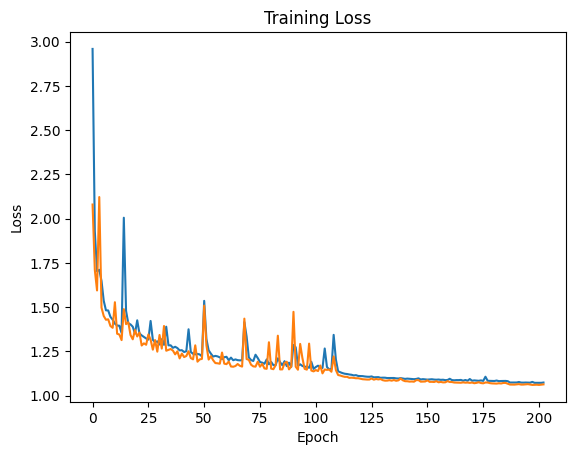

In [20]:
model_folder = "./models/ym-2l"

with open(os.path.join(model_folder, "train_loss.txt"), 'r') as f:
    train = [float(i.strip()) for i in f.readlines()]

with open(os.path.join(model_folder, "validation_loss.txt"), 'r') as f:
    valid = [float(i.strip()) for i in f.readlines()]

plt.title(label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train)
plt.plot(valid)

epoch = len(train)
checkpoint_filename = os.path.join(model_folder, f"epoch{epoch:04d}.pt")
print("Loading model:", checkpoint_filename)
checkpoint = torch.load(checkpoint_filename, map_location=device)

model = SaShiMi(
    input_dim=1,
    hidden_dim=64,
    output_dim=256,
    state_dim=64,
    sequence_length=16000*8,
    block_count=2,
    encoder=Embedding(256, 64),
).to(device)

model.load_state_dict(checkpoint["model_state"])

The following code block will generate 32 samples at once and save them.

In [8]:
seed = 42
torch.manual_seed(seed)
model.eval()
with torch.no_grad():
    gen = generate_audio_sample(model, 8*16000, batch_size=32)
    gen = mu_law_decoding(gen, 256).cpu()

for i, g in enumerate(gen):
    wavfile.write(f"outputs/ym-2l/epoch{epoch:04d}-seed{seed}-{i}.wav", 16000, g.numpy())

  0%|          | 0/128000 [00:00<?, ?it/s]

Let's listen to the generated samples.

In [9]:
selected_index = 0

In [ ]:
# You can run this block repeatedly to switch to the next sample
selected = gen[selected_index]
print("Sample", selected_index)
selected_index = (selected_index + 1) % gen.size(dim=0)
plt.figure()
plt.plot(selected)
ipd.Audio(selected.numpy(), rate=16000)

## NLL Test

Next, we will compute negative log likelihood (NLL) values on the test dataset.

Note that [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) simply calculates the NLL by applying softmax internally:

$$
l_n = - \log \frac{\exp(x_{n,y_n})}{\sum_{c=1}^C \exp(x_{n,c})}
$$

PyTorch uses natural log by default. We convert this to NLL in bits by dividing the result by $\log(2)$. 

In [18]:
test_dataset = YoutubeMixDataset("./datasets/youtube-mix/test", duration=8, device=device)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

def test_nll(model):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        nll = 0.0
        for x, y in tqdm(test_dataloader, leave=False):
            y_hat = model(x)
            nll += criterion(y_hat.view(-1, 256), y.view(-1))
        nll /= len(test_dataloader)

        print("Average NLL:", nll.item())
        print("Average NLL in base 2:", (nll / torch.tensor(2.0).log()).item())
        print("Average NLL converted to probability:", (-nll).exp().item())

len(test_dataset)

111

In [19]:
test_nll(model)

  0%|          | 0/111 [00:00<?, ?it/s]

Average NLL: 1.0747634172439575
Average NLL in base 2: 1.5505558252334595
Average NLL converted to probability: 0.34137850999832153


For comparison, **the NLL value reported on the paper is 1.446** (in base 2) for SaShiMi model with 2 layers.

Although our results are worse, it's close. We believe it's reasonable to expect that our model can achieve the same or better NLL value with longer training and better hyperparameter choices.

# 2-Layer SaShiMi with GLU on Youtube Mix

In Appendix C.2.1, authors mention that swapping activations with [GLU](https://pytorch.org/docs/stable/generated/torch.nn.GLU.html) improves both NLL and performance. We investigate this by training a 2-Layer SaShiMi with GLU on Youtube Mix.

Note that since GLU layer halves the dimensions, we increase the output dimensions of the linear layers that precede GLU layers. This increases the parameter count of the model.

- AdamW optimizer was used with a learning rate of 0.001.
- Starting at epoch 100, the learning rate was reduced to 0.0002.
- Starting at epoch 141, the learning rate was reduced to 0.0001.

Loading model: ../models/ym-2l-glu/epoch0150.pt


<All keys matched successfully>

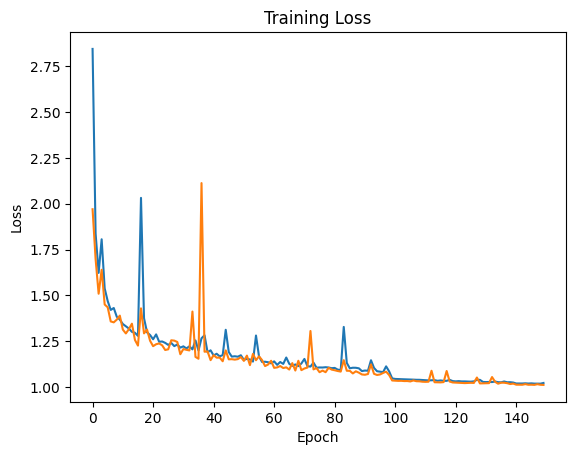

In [22]:
model_folder = "./models/ym-2l-glu"

with open(os.path.join(model_folder, "train_loss.txt"), 'r') as f:
    train = [float(i.strip()) for i in f.readlines()]

with open(os.path.join(model_folder, "validation_loss.txt"), 'r') as f:
    valid = [float(i.strip()) for i in f.readlines()]

plt.title(label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train)
plt.plot(valid)

epoch = len(train)
checkpoint_filename = os.path.join(model_folder, f"epoch{epoch:04d}.pt")
print("Loading model:", checkpoint_filename)
checkpoint = torch.load(checkpoint_filename, map_location=device)

model = SaShiMi(
    input_dim=1,
    hidden_dim=64,
    output_dim=256,
    state_dim=64,
    sequence_length=16000*8,
    block_count=2,
    block_class=S4BlockGLU,
    encoder=Embedding(256, 64),
).to(device)

model.load_state_dict(checkpoint["model_state"])

## Sampling from 2-Layer SaShiMi model with GLU

In [24]:
seed = 42
torch.manual_seed(seed)
model.eval()
with torch.no_grad():
    gen = generate_audio_sample(model, 8*16000, batch_size=32)
    gen = mu_law_decoding(gen, 256).cpu()

for i, g in enumerate(gen):
    wavfile.write(f"outputs/ym-2l-glu/epoch{epoch:04d}-seed{seed}-{i}.wav", 16000, g.numpy())

  0%|          | 0/128000 [00:00<?, ?it/s]

In [25]:
selected_index = 0

In [ ]:
# You can run this block repeatedly to switch to the next sample
selected = gen[selected_index]
print("Sample", selected_index)
selected_index = (selected_index + 1) % gen.size(dim=0)
plt.figure()
plt.plot(selected)
ipd.Audio(selected.numpy(), rate=16000)

## NLL

In [23]:
test_nll(model)

  0%|          | 0/111 [00:00<?, ?it/s]

Average NLL: 1.0214753150939941
Average NLL in base 2: 1.473677396774292
Average NLL converted to probability: 0.3600633442401886


This time, our average NLL in base 2 is quite close to 1.446, the value reported in the paper.